In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())


11.7
True


In [ ]:
# Create a MPS device
# device = torch.device("mps")
# device

In [2]:
use_cuda=torch.cuda.is_available()
device=torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
! pip install SentencePiece


In [ ]:
! pip install langid

In [ ]:
! pip install unidecode

In [ ]:
! pip install transformers


In [ ]:
! pip install pandas

In [ ]:
! pip install -U matplotlib

In [ ]:
! pip install wandb

In [3]:
! wandb login 0cf8d63ac20cff538d748e7412a8d60561ff1268

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\priya/.netrc


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split,RandomSampler, SequentialSampler
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup,GPT2Config
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 8, 6
import wandb
import re
from collections import Counter

import unidecode
import langid
import random
import torch.optim as optim

In [4]:
full_dataset =pd.read_csv('../dataset/all_quotes.csv',low_memory=False)
# full_dataset=full_dataset.head(1000) #For testing purpose only
print(full_dataset.shape)


(30000, 5)


In [5]:
full_dataset.head()

,Unnamed: 0,quotes,author,tag,other_tags
0,0,“Control of consciousness determines the quali...,"― Mihaly Csikszentmihalyi, Flow: The Psycholog...",happiness,"[' consciousness, happiness, quality-of-life']"
1,1,“Copulation is no more foul to me than death is.”,"― Walt Whitman, Leaves of Grass: The First (18...",death,"[' death, sex']"
2,2,“Hope is a dream of which we long to have. Don...,"― Peace Gypsy, Souls Deep",happiness,"[' dreamers, dreams, happiness, love, peace']"
3,3,“True devotion and humility is when you carele...,― Michael Bassey Johnson,truth,"[' acceptance, achilles-heel, admiration, affe..."
4,4,"“Truths are written, never said... Lines are d...","― Colleen Hoover, Maybe Someday",poetry,"[' love, maybe-someday, poetry, ridge-lawson']"


In [6]:

new_dataset = full_dataset[['quotes', 'tag']]
new_dataset = new_dataset[new_dataset['quotes'].apply(lambda x: unidecode.unidecode(x).isascii())]

# Set the seed for reproducibility
random.seed(123)

# Define a function to detect the language of a string
def detect_language(text):
    return langid.classify(text)[0]

# Add a new column to the DataFrame with the language of each quote
new_dataset['language'] = new_dataset['quotes'].apply(detect_language)

# Filter the DataFrame to keep only the rows where the language is English
new_dataset = new_dataset[new_dataset['language'] == 'en']

# Drop the language column from the DataFrame
new_dataset = new_dataset.drop('language', axis=1)
new_dataset = new_dataset.reset_index(drop=True)
print(new_dataset.shape)

(28699, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


           tag  count
2        truth   2926
6         love   2919
8      success   2917
0    happiness   2916
1        death   2905
9         time   2879
7      science   2867
5      romance   2842
4  inspiration   2774
3       poetry   2754


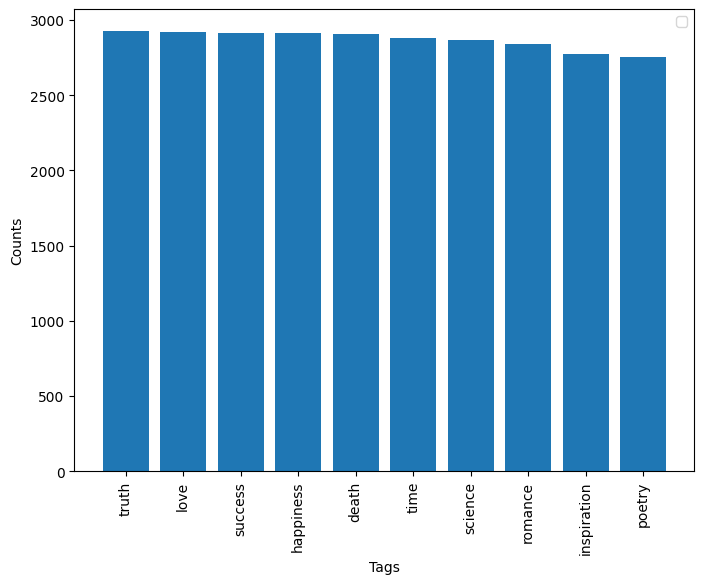

In [37]:
# Lowercase the text
tag_string = ','.join(new_dataset['tag'])
tag_list = [tag.strip() for tag in tag_string.split(',')] # all tags in this list
tag_counts = Counter(tag_list)
tag_df = pd.DataFrame({'tag': tag_counts.keys(), 'count': tag_counts.values()})
tag_df = tag_df.sort_values(by='count', ascending=False)
print(tag_df)
plt.bar(tag_df['tag'][:50], tag_df['count'][:50])
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [8]:
new_dataset['quotes'] = new_dataset['quotes'].str.replace('“', '')
new_dataset['quotes'] = new_dataset['quotes'].str.replace('”', '')

In [9]:
#Data preprocessing
# Remove new line
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: re.sub(r'\n+', ' ', x))

# Lowercase the text
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: x.lower())

In [10]:
def plot_word_distribution(sentences):
    # Initialize a dictionary to keep track of the count of sentences in each bin
    bin_counts = {'0-100': 0, '100-200': 0, '200-300': 0, '300-400': 0, '400-500': 0, '500-600': 0, '600+': 0}
    sentence_lengths = []
    
    for sentence in sentences:
        # Get the length of the sentence in words
        length = len(sentence.split())
        sentence_lengths.append(length)
        
        # Update the count of sentences in the appropriate bin
        if length <= 100:
            bin_counts['0-100'] += 1
        elif length <= 200:
            bin_counts['100-200'] += 1
        elif length <= 300:
            bin_counts['200-300'] += 1
        elif length <= 400:
            bin_counts['300-400'] += 1
        elif length <= 500:
            bin_counts['400-500'] += 1
        elif length <= 600:
            bin_counts['500-600'] += 1
        else:
            bin_counts['600+'] += 1   
    # Print the counts of sentences in each bin
    print(f"Sentences with 0-100 words: {bin_counts['0-100']}")
    print(f"Sentences with 100-200 words: {bin_counts['100-200']}")
    print(f"Sentences with 200-300 words: {bin_counts['200-300']}")
    print(f"Sentences with 300-400 words: {bin_counts['300-400']}")
    print(f"Sentences with 400-500 words: {bin_counts['400-500']}")
    print(f"Sentences with 500-600 words: {bin_counts['500-600']}")
    print(f"Sentences with 600+ words: {bin_counts['600+']}")

plot_word_distribution(new_dataset['quotes'])


Sentences with 0-100 words: 27432
Sentences with 100-200 words: 1088
Sentences with 200-300 words: 142
Sentences with 300-400 words: 23
Sentences with 400-500 words: 9
Sentences with 500-600 words: 3
Sentences with 600+ words: 2


In [11]:
def max_words_sentence(sentences):
    sentence_lengths = [len(s.split()) for s in sentences]
    max_length = max(sentence_lengths)
    max_sentence = sentences[sentence_lengths.index(max_length)]
    return max_sentence, max_length
max_words_sentence(new_dataset['quotes'])

('it was the general opinion of ancient nations, that the divinity alone was adequate to the important office of giving laws to men... and modern nations, in the consecrations of kings, and in several superstitious chimeras of divine rights in princes and nobles, are nearly unanimous in preserving remnants of it... is the jealousy of power, and the envy of superiority, so strong in all men, that no considerations of public or private utility are sufficient to engage their submission to rules for their own happiness? or is the disposition to imposture so prevalent in men of experience, that their private views of ambition and avarice can be accomplished only by artifice? — … there is nothing in which mankind have been more unanimous; yet nothing can be inferred from it more than this, that the multitude have always been credulous, and the few artful. the united states of america have exhibited, perhaps, the first example of governments erected on the simple principles of nature: and if 

In [12]:
#get the maximum sentence length
max_length_value=768

In [12]:
class QuotesDataset(Dataset):
    def __init__(self, quotes, tokenizer,max_length_value):
        self.input_ids = []
        self.attn_masks = []
        self.tokenizer = tokenizer

        for quote in quotes:
          encodings_dict = tokenizer("<|startoftext|>"+quote+"<|endoftext|>",
                                    truncation=True,
                                    max_length=max_length_value,
                                    padding="max_length") #We are using max length padding
          
          self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
          self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [14]:
#Hyper parameters
batch_size = 4
num_epochs=20
lr=1e-3
warmup_steps=800
optimizer='Adagrad'
dropout=0.25

In [15]:
#Add the tags with the quotes for training
new_dataset['tag_quotes'] = new_dataset.apply(lambda x: x['tag'] + ':' + x['quotes'], axis=1)
print(new_dataset['tag_quotes'].head())

0    happiness:control of consciousness determines ...
1    death:copulation is no more foul to me than de...
2    happiness:hope is a dream of which we long to ...
3    truth:true devotion and humility is when you c...
4    poetry:truths are written, never said... lines...
Name: tag_quotes, dtype: object


In [16]:
quotes = new_dataset['tag_quotes']
train_size = int(0.8*len(quotes))
val_size = len(quotes) - train_size
print(train_size,val_size)
train_dataset, val_dataset = random_split(quotes, [train_size, val_size])

22959 5740


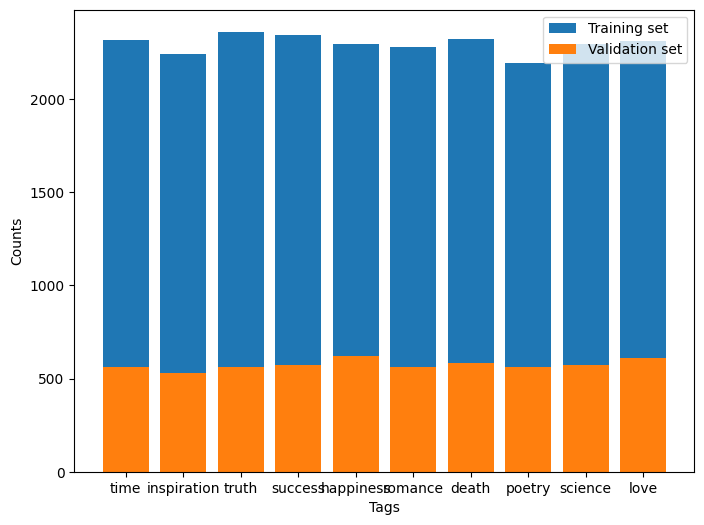

In [17]:
train_tags = [item.split(":")[0] for item in train_dataset]
val_tags =[item.split(":")[0] for item in val_dataset]

# Count the number of occurrences of each tag in each list
train_tag_counts = Counter(train_tags)
val_tag_counts = Counter(val_tags)

# Plot the tag distributions
fig, ax = plt.subplots()
ax.bar(train_tag_counts.keys(), train_tag_counts.values(), label='Training set')
ax.bar(val_tag_counts.keys(), val_tag_counts.values(), label='Validation set')
ax.set_xlabel('Tags')
ax.set_ylabel('Counts')
ax.legend()
plt.show()

In [18]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

train_tokenized_dataset=QuotesDataset(train_dataset, tokenizer,max_length_value)
val_tokenized_dataset=QuotesDataset(val_dataset, tokenizer,max_length_value)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:

train_dataloader = DataLoader(train_tokenized_dataset,
                              sampler=RandomSampler(train_tokenized_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_tokenized_dataset,
                            sampler=SequentialSampler(val_tokenized_dataset),
                            batch_size=batch_size)

In [20]:
# Load model configuration
config = GPT2Config.from_pretrained("gpt2")
config.dropout=dropout
# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(device)

In [21]:
# Using AdamW optimizer with default parameters
optimizer = optim.Adagrad(model.parameters(), lr=lr)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*num_epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

In [22]:
wandb.init(
    # set the wandb project where this run will be logged
    project="quotes-generator-project-4",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate":lr, 
    "batch_size":batch_size,
    "warmup_steps":warmup_steps,
    "optimizer":optimizer,
    "num_epochs":num_epochs,
    "dropout":dropout,
    }
)
#Need to add batch size, optimization algorithm, dropout rate, gpt-2 models

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pkirupaharan (quotes). Use `wandb login --relogin` to force relogin


In [ ]:
training_stats = []
all_training_loss=[]
all_valid_loss=[]
for epoch_i in range(num_epochs):
  print(f'Beginning epoch {epoch_i+1} of {num_epochs}')
  total_train_loss = 0
  model.train()

  # Labels are shifted by 1 timestep
  for step, batch in enumerate(train_dataloader):
    #input_ids (torch.LongTensor of shape (batch_size, input_ids_length)) — input_ids_length = sequence_length if past_key_values is None else past_key_values[0][0].shape[-2] (sequence_length of input past key value states). Indices of input sequence tokens in the vocabulary.

    #labels (torch.LongTensor of shape (batch_size, sequence_length), optional) — Labels for language modeling. Note that the labels are shifted inside the model, i.e. you can set labels = input_ids Indices are selected in [-100, 0, ..., config.vocab_size] All labels set to -100 are ignored (masked), the loss is only computed for labels in [0, ..., config.vocab_size]

    #attention_mask (torch.FloatTensor of shape (batch_size, sequence_length), optional) — Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:
    #1 for tokens that are not masked,
    #0 for tokens that are masked.
    
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks)
    #loss: Cross Entropy loss is used by the model (torch.FloatTensor of shape (1,), optional, returned when labels is provided) — Language modeling loss (for next-token prediction).
    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss
    loss.backward()
    optimizer.step()
    scheduler.step()
    # log metrics to wandb
    wandb.log({"Training Loss": loss})

  all_training_loss.append(total_train_loss)
  avg_train_loss = total_train_loss / len(train_dataloader)
  print(f'Average Training Loss: {avg_train_loss}.')
  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                         attention_mask = b_masks,
                         labels=b_labels)
          
        loss = outputs[0]  
        wandb.log({"Validation Loss": loss})

    batch_loss = loss.item()
    total_eval_loss += batch_loss   

  all_valid_loss.append(total_eval_loss)
  avg_val_loss = total_eval_loss / len(val_dataloader)  
  print(f'Validation loss: {avg_val_loss}.')
  print()
  torch.save(model.state_dict(), f'gpt2_finetuned_epoch_{epoch_i}.pt')
  
  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
      }
  )
wandb.finish()

Text(0, 0.5, 'Loss')

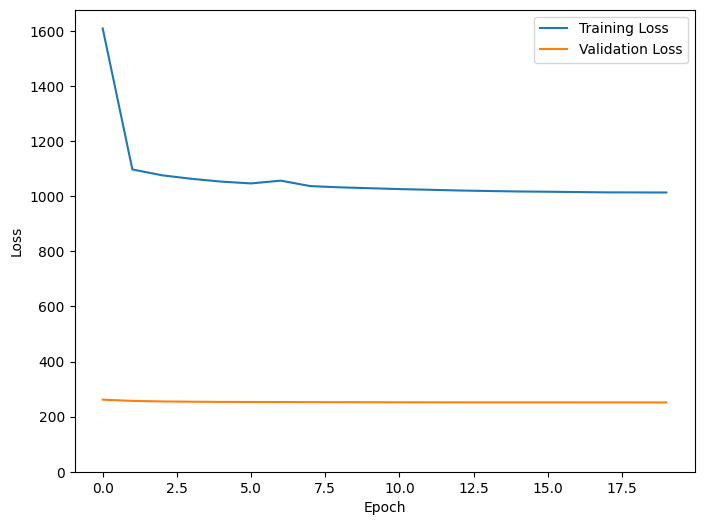

In [25]:
plt.plot(all_training_loss, label='Training Loss')
plt.plot(all_valid_loss, label='Validation Loss')
plt.ylim(bottom=0)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [29]:
test_dataset =pd.read_csv('selected_data.csv',low_memory=False)
test_dataset['tag_quotes'] = test_dataset.apply(lambda x: x['tag'] + ':' + x['quote'], axis=1)
print(test_dataset.shape)
print(test_dataset['tag_quotes'].head())

(3000, 3)
0    death:Love never dies a natural death. It dies...
1    death:My dear,Find what you love and let it ki...
2    death:If you gave someone your heart and they ...
3    death:Things we lose have a way of coming back...
4    death:We are all alone, born alone, die alone,...
Name: tag_quotes, dtype: object


In [33]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

use_cuda=torch.cuda.is_available()
device=torch.device('cuda:0' if use_cuda else 'cpu')
model_path = "../../../models/gpt2_finetuned_epoch_9.pt"
my_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')
model_state_dict = torch.load(model_path, map_location=torch.device(device))


# Create a new model and load the state dict
config = GPT2Config.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2',config=config)
model.resize_token_embeddings(len(my_tokenizer))

model.load_state_dict(model_state_dict)
model.to(device)
test_tokenized_dataset=QuotesDataset(test_dataset['tag_quotes'], my_tokenizer,768)

# Define the evaluation dataloader
test_dataloader = torch.utils.data.DataLoader(test_tokenized_dataset, batch_size=4)

all_test_loss=[]
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                         attention_mask = b_masks,
                         labels=b_labels)
          
        loss = outputs[0] 
    all_test_loss.append(loss.item())

print(len(all_test_loss))
perplexity = torch.exp(torch.tensor(sum(all_test_loss)/len(all_test_loss)))

print(f'Perplexity: {perplexity.item()}')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


750
Perplexity: 1.3715728521347046


In [35]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel,GPT2Config

# Load the fine-tuned GPT-2 model and tokenizer
model_path = "gpt2_finetuned_epoch_19.pt"
my_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')
model_state_dict = torch.load(model_path, map_location=torch.device(device))


# Create a new model and load the state dict
config = GPT2Config.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2',config=config)
model.resize_token_embeddings(len(my_tokenizer))

model.load_state_dict(model_state_dict)


prompt = "Control of consciousness"

generated = torch.tensor(my_tokenizer.encode(prompt)).unsqueeze(0)
sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=True)))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Control of consciousness; or to say he knew but nothing about consciousness; he was a philosopher. i have learned to live by a certain pattern and this is the essence of my existence; i think of myself as a thinker. the problem is not, therefore, the existence of a thought or a knowledge but the existence of an understanding of the world around it. i do not want to think about existence in general, but i would like to live by that.


1: Control of consciousness and perception, we need to be willing to listen to whatever the world wants us to hear as well as to understand when something is happening. the most exciting and exciting thing about the brain is that it is an evolutionary force acting for us - it helps us to keep track of what we are doing. we cannot just shut it off without losing the ability to communicate.


2: Control of consciousness in the non-being-anaturing mind is a subject of intense fascination by anyone who has been taught to love themselves. the first thing i n